In [1]:
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
from pandas_profiling import ProfileReport

plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['figure.figsize']=[12,0]

# Data Report

In [3]:
hr=pd.read_csv('data/turnover.csv')
hr.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [4]:
profile = ProfileReport(hr)

In [5]:
profile

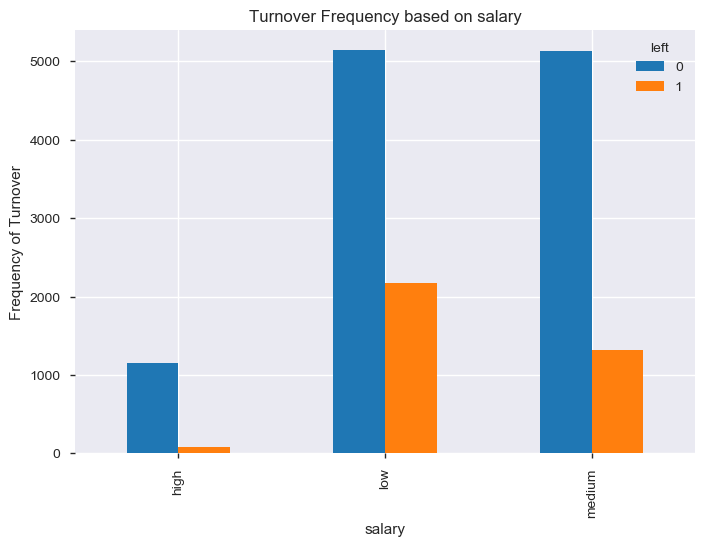

In [6]:
pd.crosstab(hr.salary, hr.left).plot(kind='bar')
plt.title("Turnover Frequency based on salary")
plt.xlabel('salary')
plt.ylabel('Frequency of Turnover')
plt.show()

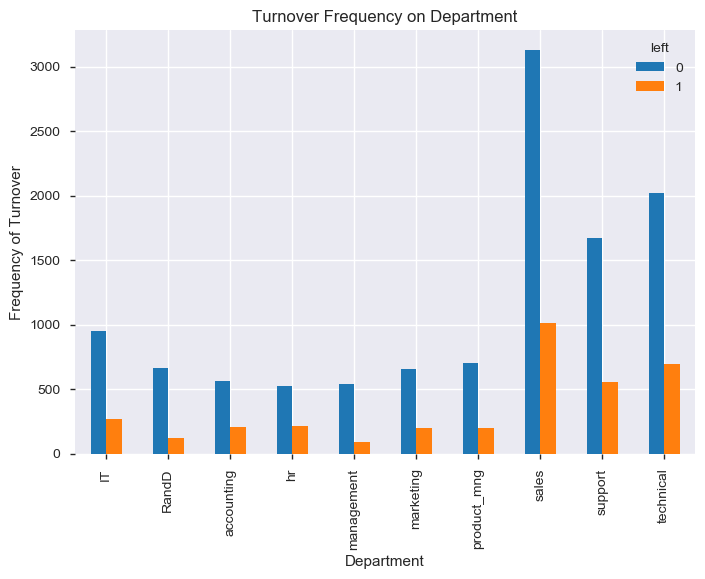

In [7]:
pd.crosstab(hr.sales, hr.left).plot(kind='bar')
plt.title("Turnover Frequency on Department")
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

# Encoding Categorical Features

In [8]:
cat_vars=['sales','salary']
for var in cat_vars:
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr = hr.join(cat_list)

In [9]:
hr.drop(columns=['sales','salary'], axis=1, inplace=True)

# Balance Check

In [10]:
from yellowbrick.target import ClassBalance
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)

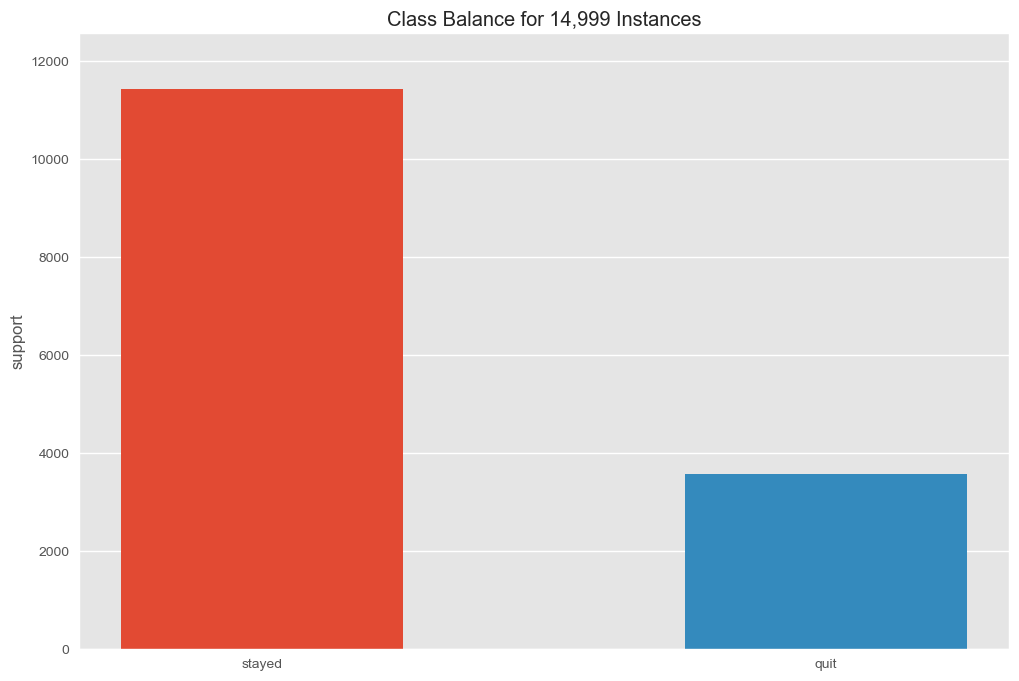

In [29]:
visu = ClassBalance(labels=['stayed','quit']).fit(hr.left)
visu.show()

# Test and Train Test 

In [12]:
X = hr.loc[:,hr.columns != 'left']
y = hr.left

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# Interactive Decision Tree Classifier

In [14]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [30]:
@interact
def plot_tree(crit=['gini','entropy'],
              split=['best','random'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter=split,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf)
    estimator.fit(X_train,y_train)
    print("Decision Tree Training Accuracy",accuracy_score(y_train,estimator.predict(X_train)))
    print("Decision Tree Test Accuracy",accuracy_score(y_test,estimator.predict(X_test)))
    
    graph = Source(tree.export_graphviz(estimator,out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed','quit'],
                                       filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    return estimator
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

# Interactive Random Forest Classifier

In [31]:
@interact
def plot_tree(crit=['gini','entropy'],
              bootstrap=['True','False'],
              depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
              forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = RandomForestClassifier(random_state=0,
                                      criterion=crit,
                                      bootstrap=bootstrap,
                                      n_estimators=forests,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf,
                                      n_jobs=-1,
                                      verbose=False)
    estimator.fit(X_train,y_train)
    print("Random Forest Training Accuracy",accuracy_score(y_train,estimator.predict(X_train)))
    print("Random Forest Test Accuracy",accuracy_score(y_test,estimator.predict(X_test)))
    num_tree = estimator.estimators_[0]
    print('\Visualizing Tree:',0)
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed','quit'],
                                       filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    return estimator
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

# Feature Importance and Evaluation Metrics

In [32]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

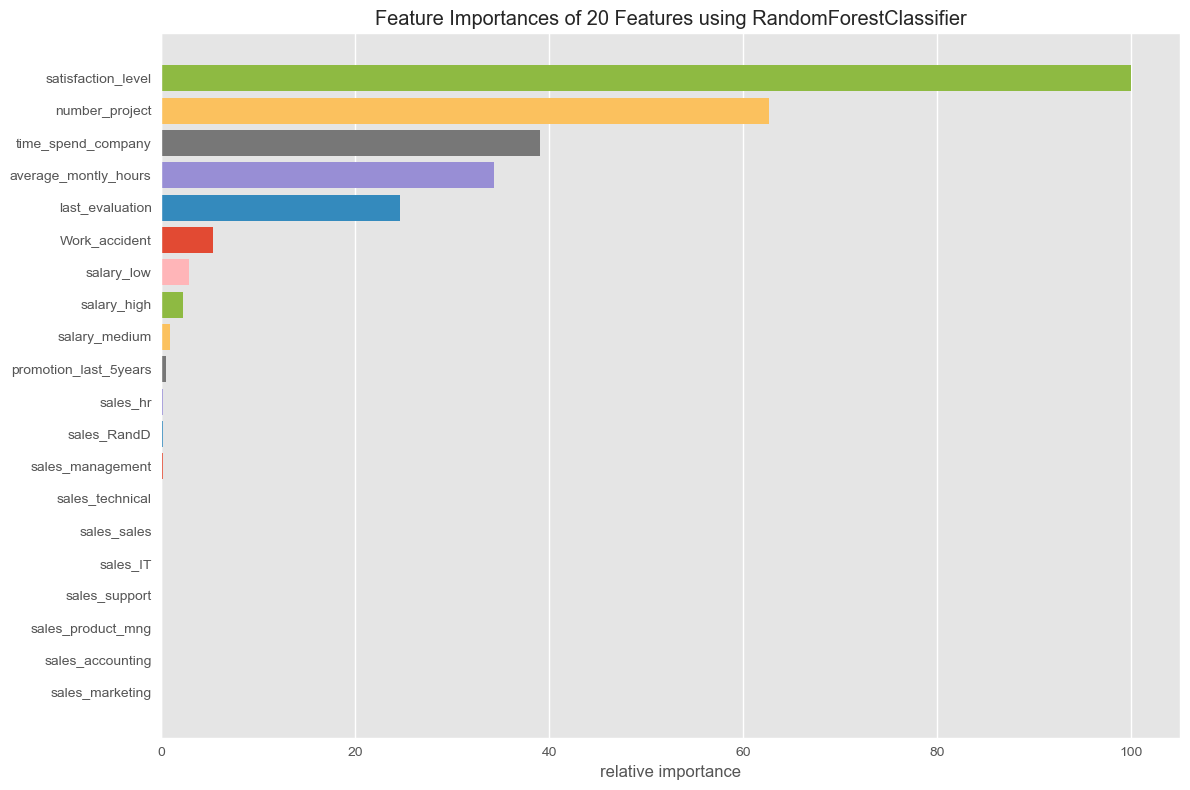

In [33]:
rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0,
                       verbose=False, warm_start=False)
viz=FeatureImportances(rf)
viz.fit(X_train,y_train)
viz.show()

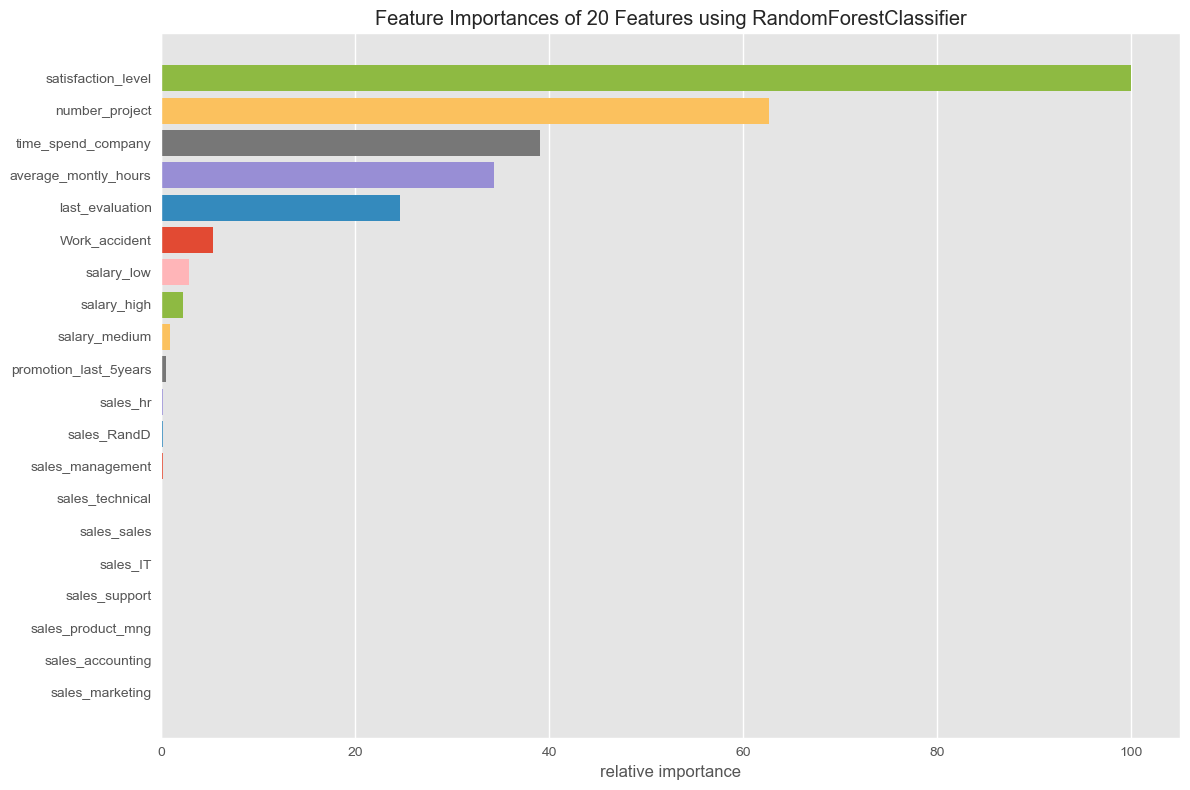

In [34]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
viz=FeatureImportances(rf)
viz.fit(X_train,y_train)
viz.show()

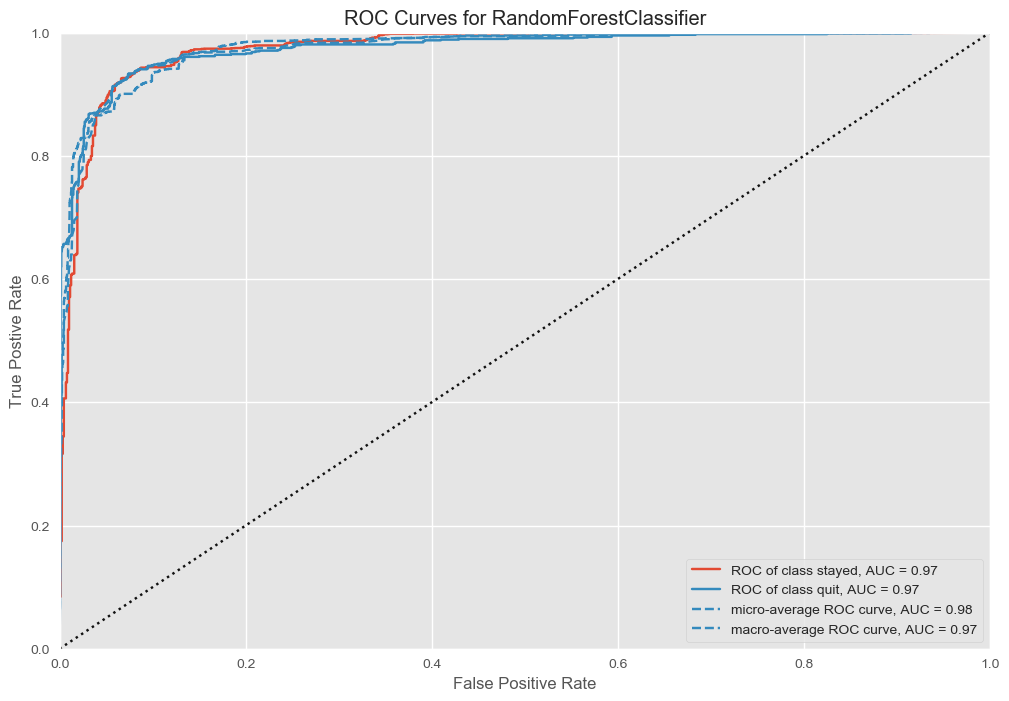

In [35]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf,classes=['stayed','quit'])
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof();


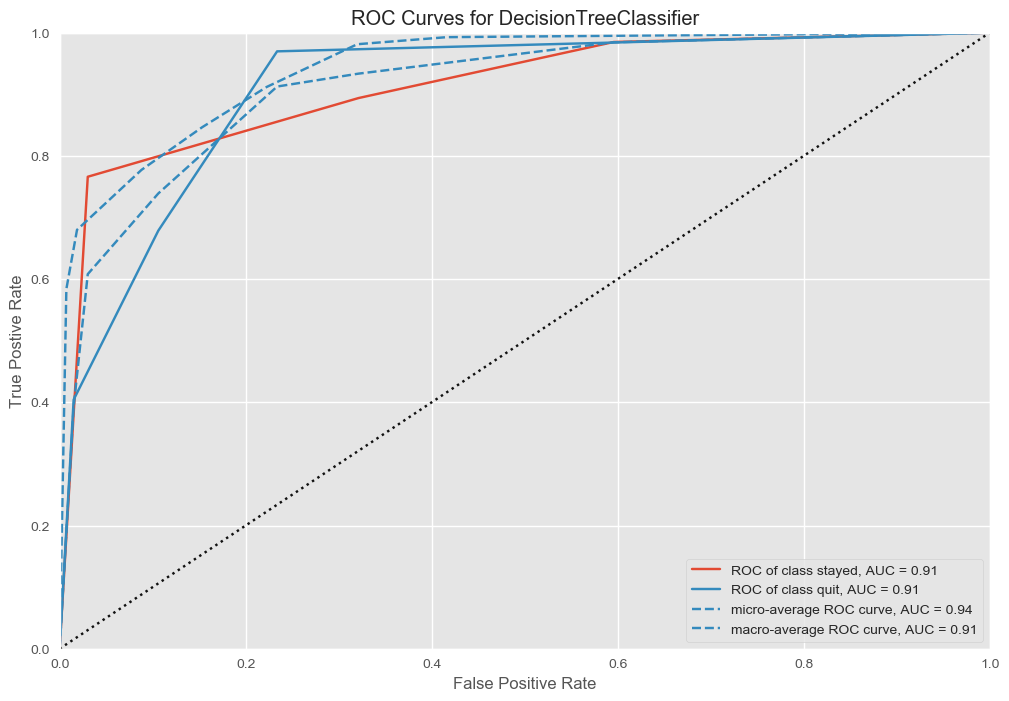

In [36]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(dt,classes=['stayed','quit'])
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof();